# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import sys, os


os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")
sys.path.append("/Users/samuel.gruffaz/Documents/PEcollab")
from leaspy.api import Leaspy

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory




In [74]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

def plot_points(ax, dataset, nb_ind_plot, dimension):
    tps=dataset.timepoints
    Y=dataset.values
    mask=dataset.mask
    for i in range(nb_ind_plot):
        ind=mask[i].bool().all(axis=1)
        
        Z=Y[i,ind]
        tpsi=tps[i,ind]
       
      
        for j in range(dimension):
            ax[i,j].plot(tpsi, Z[:,j], "o")
            

def plot_fit(ax, results, model, dataset,nb_ind_plot, dimension):
    tps=dataset.timepoints
    
    for i in range(nb_ind_plot):
        tpts=tps[i,:dataset.nb_observations_per_individuals[i]].numpy()
        
        params = results._individual_parameters[results._indices[i]]
        params["tpts"]=tpts
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

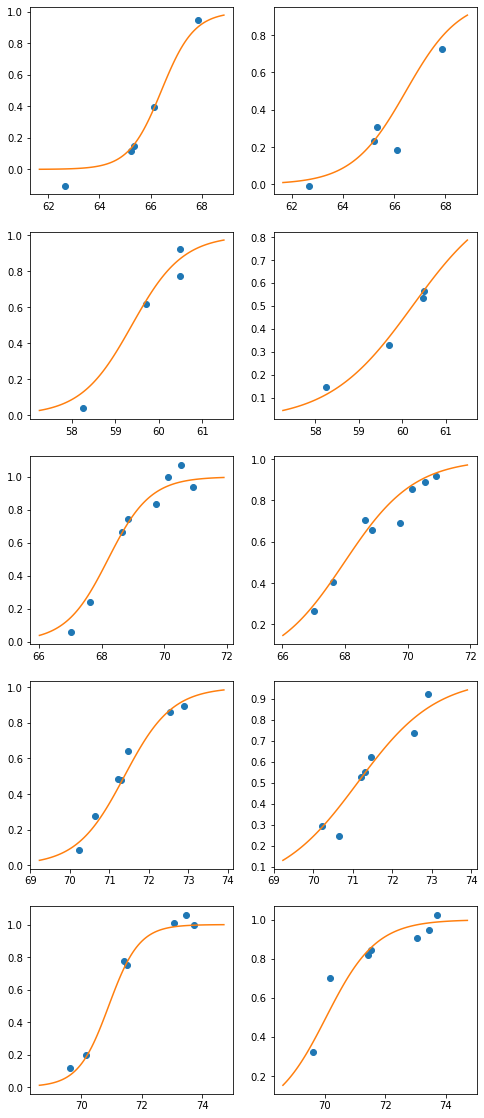

In [21]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.07]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1331

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.1185

Personalization scipy_minimize took: 8s
erreur projection
0.0022948193
1
2
temps opti quadra
0.0045070000000038135

The standard deviation of the noise at the end of the calibration is:
0.1185

Calibration took: 50s

The standard deviation of the noise at the end of the personalization is:
0.1052

Personalization scipy_minimize took: 11s
erreur projection
0.0014500144
1
2
temps opti quadra
0.0042210000000011405


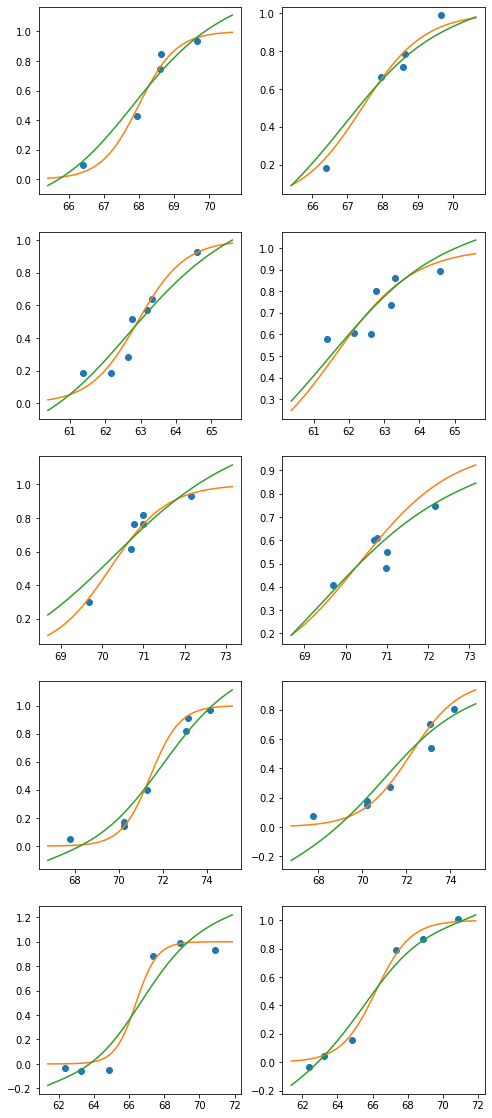

In [5]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

In [72]:
data = Data.from_csv_file(os.path.join('example','start','inputs', 'data_normalized.csv'))
dataset = Dataset(data)

In [33]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dimension=4

logi=lambda: x: 1./(1.+torch.exp(-x))
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1056

Calibration took: 12s

The standard deviation of the noise at the end of the personalization is:
0.0986

Personalization scipy_minimize took: 25s
erreur projection
0.003049659
1
2
4
temps opti quadra
0.011233000000004267

The standard deviation of the noise at the end of the calibration is:
0.1013

Calibration took: 4min 3s

The standard deviation of the noise at the end of the personalization is:
0.0948

Personalization scipy_minimize took: 42s
erreur projection
0.003307317
1
2
temps opti quadra
0.004680000000007567
tensor([81.6610, 82.1360, 82.6820, 83.1390, 83.6910, 84.6550, 85.6910, 86.6630,
        87.6390])
tensor([[0.4444, 0.0400, 0.0000, 0.0000],
        [0.6000, 0.0000, 0.0000, 0.2000],
        [0.3927, 0.0400, 0.0000, 0.2000],
        [0.5851, 0.0000, 0.0000, 0.0000],
        [0.5704, 0.0000, 0.0000, 0.0000],
        [0.5556, 0.2000, 0.1000, 0.2000],
        [0.7184, 0.2000, 0.1000, 0.6000],
      

TypeError: plot_fit() takes 5 positional arguments but 6 were given

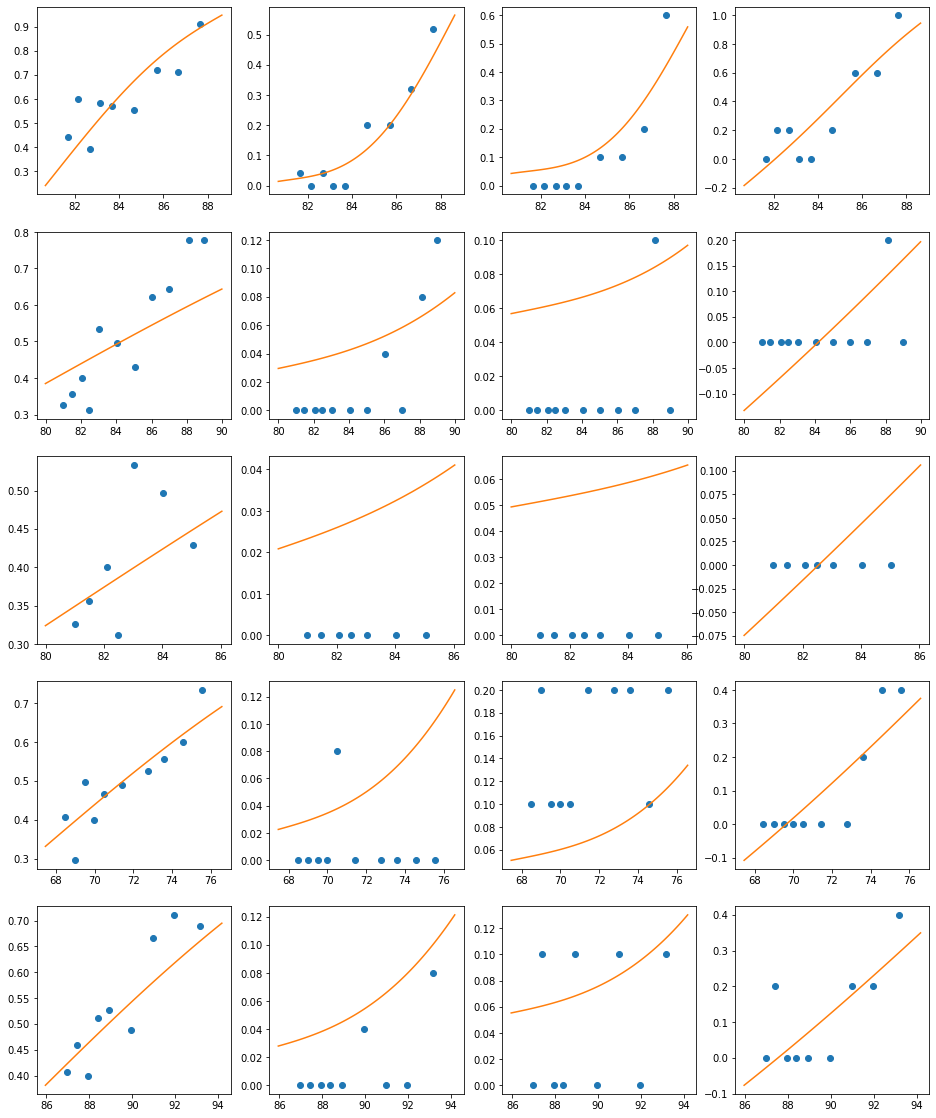

In [59]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

In [63]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dimension=4

logi=lambda x: 1./(1.+torch.exp(-x))

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)




The standard deviation of the noise at the end of the calibration is:
Y0: 0.1066
Y1: 0.0533
Y2: 0.0812
Y3: 0.1518

Calibration took: 13s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.1017
Y1: 0.0485
Y2: 0.0794
Y3: 0.1390

Personalization scipy_minimize took: 29s
erreur projection
0.012522421
1
temps opti quadra
0.005231000000094355

The standard deviation of the noise at the end of the calibration is:
Y0: 0.1123
Y1: 0.0547
Y2: 0.0805
Y3: 0.1502

Calibration took: 3min 57s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0978
Y1: 0.0483
Y2: 0.0777
Y3: 0.1366

Personalization scipy_minimize took: 47s
erreur projection
0.007886497
temps opti quadra
0.011304999999993015


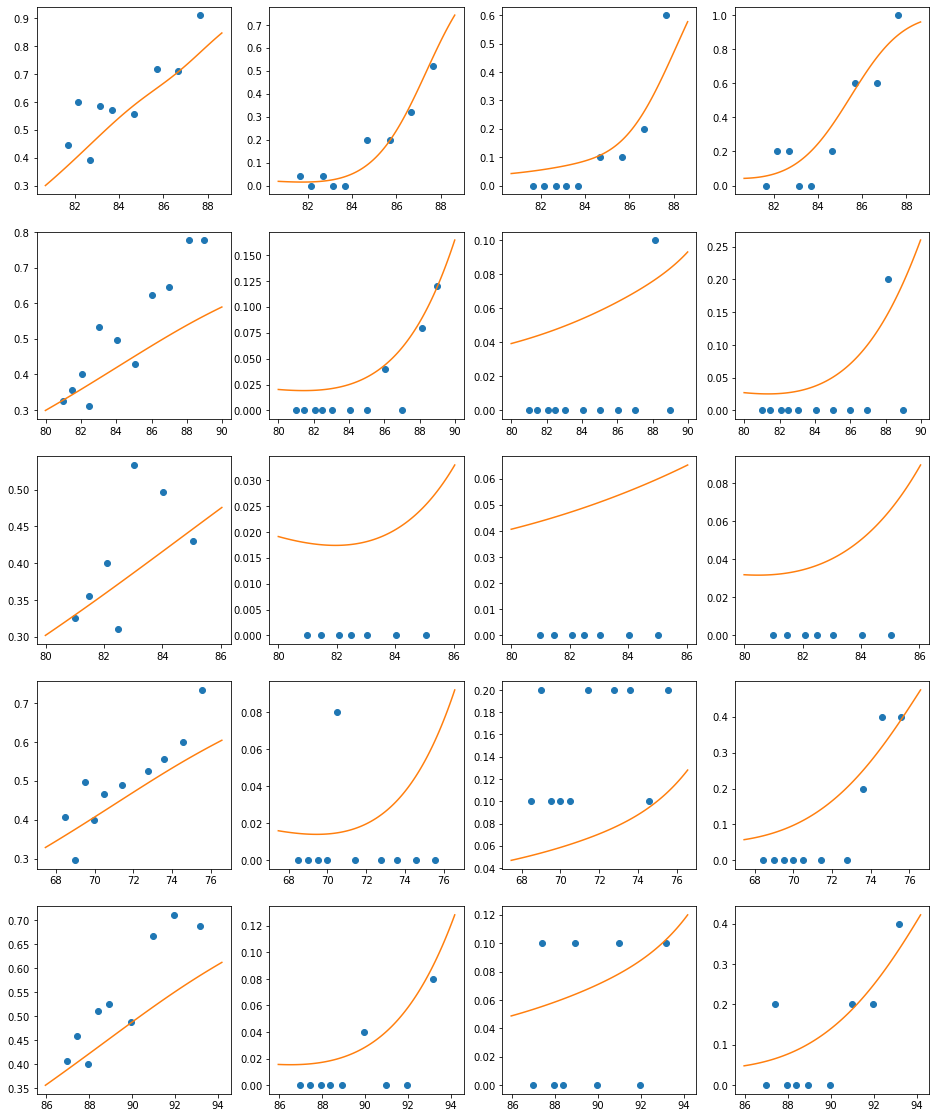

In [75]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [77]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

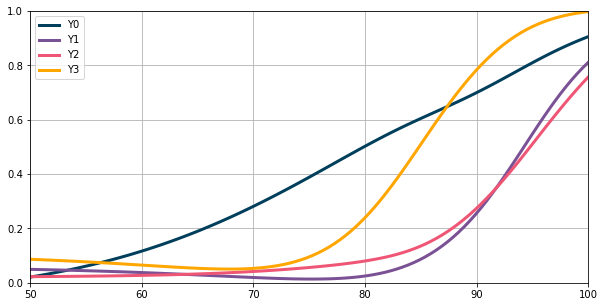

In [79]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [80]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=4

logi=lambda x: 1./(1.+torch.exp(-x))

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":4,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)


The standard deviation of the noise at the end of the calibration is:
Y0: 0.0756
Y1: 0.0480
Y2: 0.0827
Y3: 0.1425

Calibration took: 15s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0662
Y1: 0.0438
Y2: 0.0809
Y3: 0.1306

Personalization scipy_minimize took: 43s
erreur projection
0.006587433
temps opti quadra
0.011199999999917054

The standard deviation of the noise at the end of the calibration is:
Y0: 0.0740
Y1: 0.0479
Y2: 0.0804
Y3: 0.1427

Calibration took: 4min 43s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0651
Y1: 0.0436
Y2: 0.0785
Y3: 0.1308

Personalization scipy_minimize took: 1min 1s
erreur projection
0.011892758
temps opti quadra
0.011567999999897438

The standard deviation of the noise at the end of the calibration is:
Y0: 0.0760
Y1: 0.0527
Y2: 0.0788
Y3: 0.1448

Calibration took: 9min 2s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0656
Y1: 0.0439
Y2: 0.0769
Y3: 0

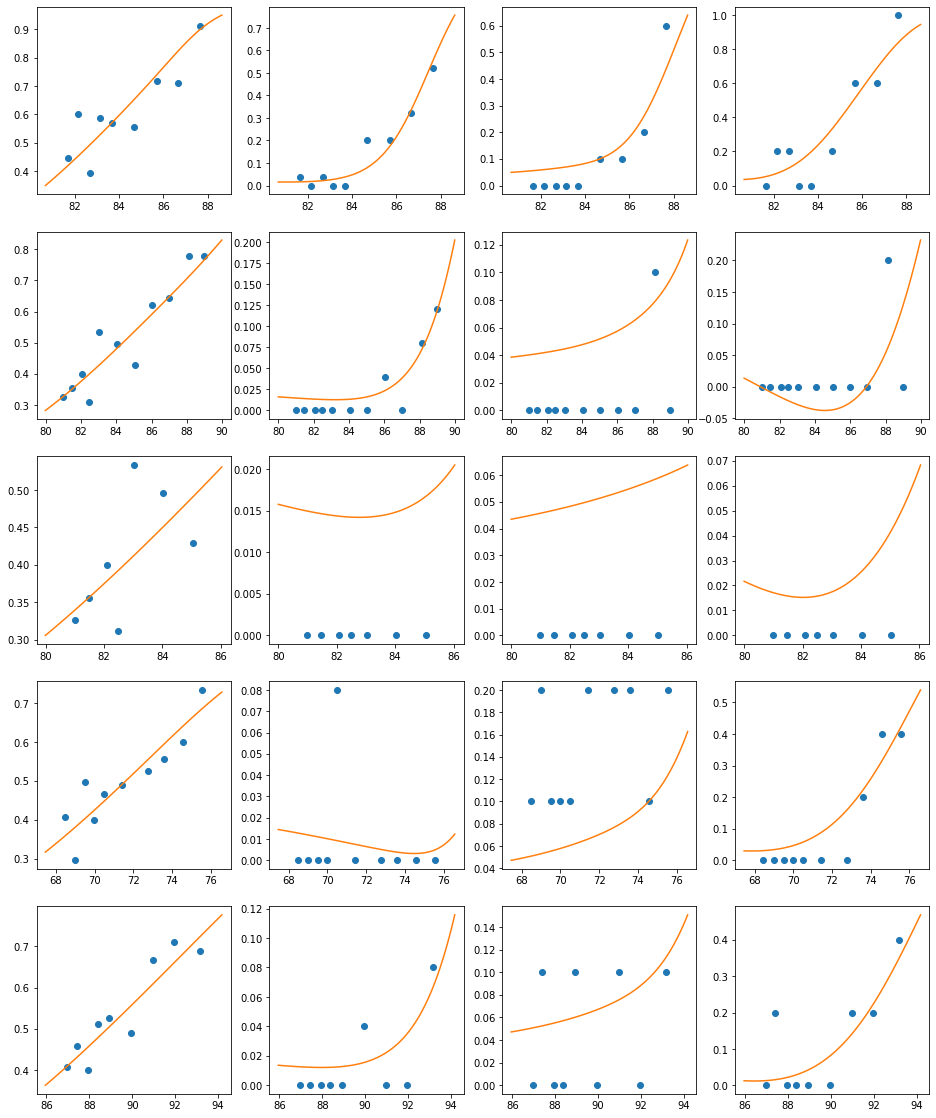

In [81]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [82]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

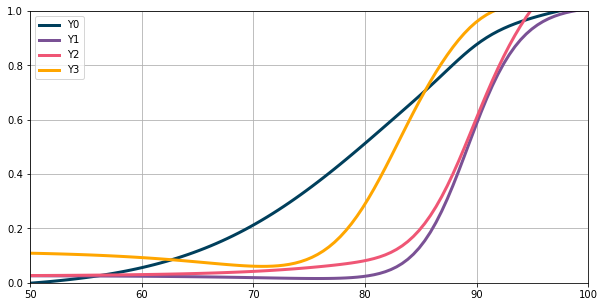

In [83]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [84]:
os.chdir("/Users/samuel.gruffaz/Documents/data")
data = Data.from_csv_file("ADNI_img_clean.csv")
dataset = Dataset(data)

ValueError: The second column of the input csv must be 'Time'

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=4

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":4,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)